<a href="https://colab.research.google.com/github/farouk/epl-simulation/blob/main/Arsenal_EPL_MonteCarlo_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arsenal EPL Title Race – Monte Carlo Simulation

## 1. Problem Statement
Can Arsenal win the Premier League this season based on current league standings and the remaining fixtures?

This notebook explores the question using a simple statistical model rather than expert opinion or pundit analysis.

---

## 2. Data Source
- English Premier League match data from **Football-Data.co.uk**
- Real fixtures and results
- All 20 EPL teams included

---

## 3. Modelling Assumptions
- Goals scored follow a Poisson distribution
- Teams have different attacking and defensive strengths
- Home and away performances are modelled separately
- EPL tie-break rules apply:  
  **Points → Goal Difference → Goals Scored**
- Injuries, transfers, suspensions, and referee effects are not modelled

---

## 4. Data Loading & Cleaning
Load the EPL season CSV and split matches into:
- Matches already played
- Remaining fixtures to be simulated

---

In [1]:
# === Setup ===
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import math

# Config
CSV_PATH = '/content/E0.csv'   # Upload Football-Data EPL CSV and set path
N_SIM = 100_000
SEED = 42

rng = np.random.default_rng(SEED)


In [2]:
# === Load Played Matches from Football-Data.co.uk ===
df = pd.read_csv(CSV_PATH)

required_cols = {'HomeTeam','AwayTeam','FTHG','FTAG'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f'Missing columns: {missing}')

df = df.dropna(subset=['HomeTeam','AwayTeam']).copy()

played = df.dropna(subset=['FTHG','FTAG']).copy()
remaining = df[df['FTHG'].isna() | df['FTAG'].isna()].copy()

teams = sorted(set(df['HomeTeam']).union(set(df['AwayTeam'])))
print(f'Teams detected: {len(teams)}')



Teams detected: 20


In [3]:
# === Load Remaining Matches from fbref.com ===
fixtures = pd.read_csv("/content/fixtures.csv")
fixtures = fixtures[["Home","Away"]].rename(
    columns={"Home":"HomeTeam","Away":"AwayTeam"}
)

remaining = fixtures.copy()
print("Remaining fixtures:", len(remaining))
remaining.head()

print("Played matches:", len(played))



Remaining fixtures: 190
Played matches: 190


In [4]:
# === Map and fix names across both data sources ===
name_map = {
    "Manchester City": "Man City",
    "Manchester Utd": "Man United",
    "Newcastle Utd": "Newcastle",
    "Leeds United": "Leeds",
    "Nott'ham Forest": "Nott'm Forest",
}

remaining["HomeTeam"] = remaining["HomeTeam"].replace(name_map)
remaining["AwayTeam"] = remaining["AwayTeam"].replace(name_map)

set(remaining["HomeTeam"]) - set(teams)
set(remaining["AwayTeam"]) - set(teams)


set()

## 5. Current League Table
Reconstruct the current league table from actual match results:
- Matches played
- Points
- Goals for / against
- Goal difference

---

In [5]:
# === League Table Utilities ===
def init_table(teams):
    return {t: {'Pts':0,'GF':0,'GA':0,'GD':0,'P':0} for t in teams}

def apply_match(table, home, away, hg, ag):
    table[home]['P'] += 1
    table[away]['P'] += 1

    table[home]['GF'] += hg; table[home]['GA'] += ag
    table[away]['GF'] += ag; table[away]['GA'] += hg

    table[home]['GD'] = table[home]['GF'] - table[home]['GA']
    table[away]['GD'] = table[away]['GF'] - table[away]['GA']

    if hg > ag:
        table[home]['Pts'] += 3
    elif hg < ag:
        table[away]['Pts'] += 3
    else:
        table[home]['Pts'] += 1
        table[away]['Pts'] += 1

def champion(table):
    return max(table.keys(), key=lambda t: (table[t]['Pts'], table[t]['GD'], table[t]['GF']))


In [6]:
# === Current Table from Played Matches ===
table_now = init_table(teams)
for r in played.itertuples(index=False):
    apply_match(table_now, r.HomeTeam, r.AwayTeam, int(r.FTHG), int(r.FTAG))


## 6. Team Strength Estimation (Poisson Model)
Estimate team attacking and defensive strengths relative to league averages:
- Home attack & defence
- Away attack & defence

These parameters are used to generate expected goals.

---

## 7. Match Simulation Logic
Simulate individual match scorelines using:
- Poisson-distributed goals
- Team-specific attack and defence parameters
- Home advantage

---

In [7]:
# === Poisson Parameters (Home/Away Strengths) ===
league_home_avg = played['FTHG'].mean()
league_away_avg = played['FTAG'].mean()

home_scored = played.groupby('HomeTeam')['FTHG'].mean().reindex(teams).fillna(league_home_avg)
home_conceded = played.groupby('HomeTeam')['FTAG'].mean().reindex(teams).fillna(league_away_avg)
away_scored = played.groupby('AwayTeam')['FTAG'].mean().reindex(teams).fillna(league_away_avg)
away_conceded = played.groupby('AwayTeam')['FTHG'].mean().reindex(teams).fillna(league_home_avg)

atk_home = home_scored / league_home_avg
def_home = home_conceded / league_away_avg
atk_away = away_scored / league_away_avg
def_away = away_conceded / league_home_avg

def simulate_score(home, away):
    lam_home = atk_home[home] * def_away[away] * league_home_avg
    lam_away = atk_away[away] * def_home[home] * league_away_avg
    return int(rng.poisson(lam_home)), int(rng.poisson(lam_away))


## 8. Monte Carlo Season Simulation
Simulate the remaining fixtures **100,000 times**:
- Update league table each simulation
- Apply EPL tie-break rules
- Record league winner

---

In [8]:
# === Monte Carlo Season Simulation ===

arsenal_wins = 0
final_points = []   # optional: store Arsenal final points per simulation

for _ in tqdm(range(N_SIM)):
    # Start from current league table
    table = {t: table_now[t].copy() for t in teams}

    # Simulate remaining fixtures
    for r in remaining.itertuples(index=False):
        hg, ag = simulate_score(r.HomeTeam, r.AwayTeam)
        apply_match(table, r.HomeTeam, r.AwayTeam, hg, ag)

    # Track Arsenal final points (optional but useful)
    final_points.append(table["Arsenal"]["Pts"])

    # Check champion
    if champion(table) == "Arsenal":
        arsenal_wins += 1

# Store final probability for Results section
arsenal_prob = arsenal_wins / N_SIM


  0%|          | 0/100000 [00:00<?, ?it/s]

## 9. Results
Calculate:
- Arsenal’s probability of winning the league
- Approximate confidence interval
- Stability of the simulation results

---

In [9]:
import math

print(f"Arsenal title probability: {arsenal_prob:.2%}")

se = math.sqrt(arsenal_prob * (1 - arsenal_prob) / N_SIM)
ci_low = arsenal_prob - 1.96 * se
ci_high = arsenal_prob + 1.96 * se

print(f"Approx 95% CI: [{ci_low:.2%}, {ci_high:.2%}]")


Arsenal title probability: 66.01%
Approx 95% CI: [65.72%, 66.31%]


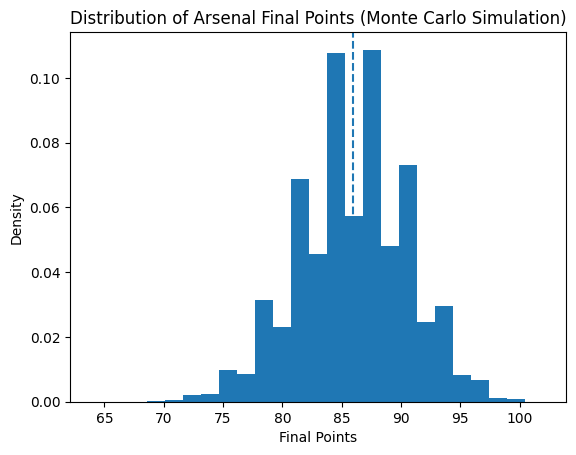

In [11]:
import numpy as np

mean_pts = np.mean(final_points)

plt.hist(final_points, bins=25, density=True)
plt.axvline(mean_pts, linestyle='--')
plt.title("Distribution of Arsenal Final Points (Monte Carlo Simulation)")
plt.xlabel("Final Points")
plt.ylabel("Density")
plt.show()


In [12]:
# === Attack / Defence Comparison for Title Contenders ===

import pandas as pd

# Pick contenders: Arsenal + current top challengers
contenders = ["Arsenal", "Man City", "Liverpool", "Tottenham"]

comparison = []

for team in contenders:
    comparison.append({
        "Team": team,
        "Attack (Home)": atk_home[team],
        "Attack (Away)": atk_away[team],
        "Defence (Home)": def_home[team],
        "Defence (Away)": def_away[team],
    })

comparison_df = pd.DataFrame(comparison)

# Round for readability
comparison_df = comparison_df.round(3)

comparison_df

,Team,Attack (Home),Attack (Away),Defence (Home),Defence (Away)
0,Arsenal,1.669,1.010,0.413,0.499
1,Man City,1.783,1.487,0.551,0.706
2,Liverpool,0.963,1.377,0.826,1.141
3,Tottenham,0.785,1.322,1.010,0.770


## 10. Limitations
- Statistical model, not a prediction
- Simplified assumptions
- Does not capture momentum, injuries, or tactical